# **Gesture Recognition for Smart TV**

## **Download Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!gdown https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
!unzip Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

## Import Libraries

In [3]:
# !pip install imageio import imageio.v2 as imageio
from imageio.v2 import imread
from PIL import Image
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
from skimage import transform as transf
from skimage.transform import resize
from skimage import exposure

# from scipy.misc import imread, imresize

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(77)
import random as rn
rn.seed(77)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(77)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
gesture_types = 5
batch_size = 10
# image_height = 250
# image_width = 250
# image_height = 200
# image_width = 200
# image_height = 160
# image_width = 160
image_height = 100
image_width = 100
image_samples = 30

In [6]:
q = len(train_doc)
nm_btch = q//batch_size
print(f"Number of videos/sequences in the training set: {q}")
print(f"batch size considered: {batch_size}")
print(f"Number of batches: {nm_btch}")
print(f"Number of videos/sequences captured in by the batch size: {batch_size*nm_btch}")
print(f"Remaining videos/sequences to be added after the batch is exhausted: {q - (batch_size*nm_btch)}")
print(f"Total number of batches: {nm_btch+1}\n\n\n")


r = len(val_doc)
val_nm_btch = r//batch_size
print(f"Number of videos/sequences in the training set: {r}")
print(f"batch size considered: {batch_size}")
print(f"Number of batches: {val_nm_btch}")
print(f"Number of videos/sequences captured in by the batch size: {batch_size*val_nm_btch}")
print(f"Remaining videos/sequences to be added after the batch is exhausted: {r - (batch_size*val_nm_btch)}")
print(f"Total number of batches: {val_nm_btch+1}")

Number of videos/sequences in the training set: 663
batch size considered: 10
Number of batches: 66
Number of videos/sequences captured in by the batch size: 660
Remaining videos/sequences to be added after the batch is exhausted: 3
Total number of batches: 67



Number of videos/sequences in the training set: 100
batch size considered: 10
Number of batches: 10
Number of videos/sequences captured in by the batch size: 100
Remaining videos/sequences to be added after the batch is exhausted: 0
Total number of batches: 11


## Generator

Generator 1 and 2

In [ ]:
# def generator(source_path, folder_list, batch_size, image_height, image_width,image_samples=30):
#     print( 'Source path = ', source_path, '; batch size =', batch_size)
#     img_idx = np.random.permutation(range(image_samples))
#     x = image_samples
#     y = image_width
#     z = image_height
#     while True:
#         t = np.random.permutation(folder_list)
#         num_batches = len(t)//batch_size
#         for batch in range(num_batches): # we iterate over the number of batches
#             batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#             batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
#             for folder in range(batch_size): # iterate over the batch_size
#                 imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
#                 for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#                     image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
#                     image = resize(image,(y,z,3))
#                     image = image[50:,15:(image.shape[1]-15)]
#                     image = resize(image,(y,z,3))
#                     image = image.astype(np.float32)
#                     #crop the images and resize them. Note that the images are of 2 different shape
#                     #and the conv3D will throw error if the inputs in a batch have different shapes

#                     # # First, define the shifting transformations
#                     # shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
#                     # matrix_to_topleft = transf.SimilarityTransform(translation=[-shift_x, -shift_y])
#                     # matrix_to_center = transf.SimilarityTransform(translation=[shift_x, shift_y])

#                     # # Then, perform the scaling transform with  zoom-in
#                     # scale_transforms = transf.AffineTransform(scale=(1,0.5))

#                     # # Add up the transforms
#                     # rot_plus_scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center

#                     # # Finally, apply the added-up transformation
#                     # image = transf.warp(image, rot_plus_scale_matrix)


#                     batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
#                     batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))#normalise and feed in the image
#                     batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))#normalise and feed in the image

#                 batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#             yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


#         # write the code for the remaining data points which are left after full batches
#         final_batch_size = len(t) - (batch_size*num_batches)
#         final_batch_data = np.zeros((final_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
#         final_batch_labels = np.zeros((final_batch_size,5)) # batch_labels is the one hot representation of the output
#         for folder in range(final_batch_size): # iterate over the batch_size
#             imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
#             for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#                 image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
#                 image = resize(image,(y,z,3))
#                 image = image[50:,15:(image.shape[1]-15)]
#                 image = resize(image,(y,z,3))
#                 image = image.astype(np.float32)

#                 #crop the images and resize them. Note that the images are of 2 different shape
#                 #and the conv3D will throw error if the inputs in a batch have different shapes

#                 # # First, define the shifting transformations
#                 # shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
#                 # matrix_to_topleft = transf.SimilarityTransform(translation=[-shift_x, -shift_y])
#                 # matrix_to_center = transf.SimilarityTransform(translation=[shift_x, shift_y])

#                 # # Then, perform the scaling transform with  zoom-in
#                 # scale_transforms = transf.AffineTransform(scale=(1,0.5))

#                 # # Add up the transforms
#                 # rot_plus_scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center

#                 # # Finally, apply the added-up transformation
#                 # image = transf.warp(image, rot_plus_scale_matrix)


#                 final_batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/(np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
#                 final_batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/(np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))#normalise and feed in the image
#                 final_batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/(np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))#normalise and feed in the image

#             final_batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
#         yield final_batch_data, final_batch_labels

Generator 3

In [ ]:
# def generator(source_path, folder_list, batch_size, image_height, image_width, image_samples=30):
#     print('Source path = ', source_path, '; batch size =', batch_size)
#     x = image_samples
#     y = image_width
#     z = image_height

#     while True:
#         t = np.random.permutation(folder_list)  # Shuffle folder_list instead of using permutation
#         num_batches = len(folder_list) // batch_size

#         for batch in range(num_batches):
#             batch_data = np.zeros((batch_size, x, y, z, 3))
#             batch_labels = np.zeros((batch_size, 5))

#             for folder in range(batch_size):
#                 imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0]))
#                 img_idx = img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

#                 for idx, item in enumerate(img_idx):

#                     image_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0], imgs[item])

#                     image = imread(image_path)

#                     image = image/255.0

#                     image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
#                     image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

#                     if image.shape[0] == 360:
#                       image = image[50:len(image)-10,:]
#                     if image.shape[0] == 120:
#                       image = image[20:len(image)-10,:]

#                     image = resize(image, (y, z, 3))
#                     image = image.astype(np.float32)

#                     image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

#                     # batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
#                     # batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
#                     # batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

#                     batch_data[folder, idx, :, :, 0] = image[:, :, 0]
#                     batch_data[folder, idx, :, :, 1] = image[:, :, 1]
#                     batch_data[folder, idx, :, :, 2] = image[:, :, 2]

#                 batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

#             yield batch_data, batch_labels

#         # Remaining images after full batches
#         final_batch_size = len(folder_list) - (batch_size * num_batches)

#         if final_batch_size > 0:
#             final_batch_data = np.zeros((final_batch_size, x, y, z, 3))
#             final_batch_labels = np.zeros((final_batch_size, 5))

#             for folder in range(final_batch_size):
#                 imgs = os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0]))
#                 img_idx = img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

#                 for idx, item in enumerate(img_idx):

#                     image_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0], imgs[item])

#                     image = imread(image_path)

#                     image = image/255.0

#                     image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
#                     image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

#                     if image.shape[0] == 360:
#                       image = image[50:len(image)-10,:]
#                     if image.shape[0] == 120:
#                       image = image[20:len(image)-10,:]

#                     image = resize(image, (y, z, 3))
#                     image = image.astype(np.float32)

#                     image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

#                     # final_batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
#                     # final_batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
#                     # final_batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

#                     final_batch_data[folder, idx, :, :, 0] = image[:, :, 0]
#                     final_batch_data[folder, idx, :, :, 1] = image[:, :, 1]
#                     final_batch_data[folder, idx, :, :, 2] = image[:, :, 2]

#                 final_batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

#             yield final_batch_data, final_batch_labels

Generator 4 & 5

In [ ]:
# def generator(source_path, folder_list, batch_size, image_height, image_width, image_samples=30):
#     print('Source path = ', source_path, '; batch size =', batch_size)
#     x = image_samples
#     y = image_width
#     z = image_height

#     while True:
#         t = np.random.permutation(folder_list)  # Shuffle folder_list instead of using permutation
#         num_batches = len(folder_list) // batch_size

#         for batch in range(num_batches):
#             batch_data = np.zeros((batch_size, x, y, z, 3))
#             batch_labels = np.zeros((batch_size, 5))

#             for folder in range(batch_size):
#                 imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0]))
#                 img_idx = img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

#                 for idx, item in enumerate(img_idx):

#                     image_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0], imgs[item])

#                     image = imread(image_path)

#                     image = image/255.0

#                     image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
#                     image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

#                     if image.shape[0] == 360:
#                       image = image[50:len(image)-10,:]
#                     if image.shape[0] == 120:
#                       image = image[20:len(image)-10,:]

#                     image = resize(image, (y, z, 3))
#                     image = image.astype(np.float32)

#                     image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

#                     # batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
#                     # batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
#                     # batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

#                     batch_data[folder, idx, :, :, 0] = image[:, :, 0]
#                     batch_data[folder, idx, :, :, 1] = image[:, :, 1]
#                     batch_data[folder, idx, :, :, 2] = image[:, :, 2]

#                 batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

#             yield batch_data, batch_labels

#         # Remaining images after full batches
#         final_batch_size = len(folder_list) - (batch_size * num_batches)

#         if final_batch_size > 0:
#             final_batch_data = np.zeros((final_batch_size, x, y, z, 3))
#             final_batch_labels = np.zeros((final_batch_size, 5))

#             for folder in range(final_batch_size):
#                 imgs = os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0]))
#                 img_idx = img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

#                 for idx, item in enumerate(img_idx):

#                     image_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0], imgs[item])

#                     image = imread(image_path)

#                     image = image/255.0

#                     image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
#                     image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

#                     if image.shape[0] == 360:
#                       image = image[50:len(image)-10,:]
#                     if image.shape[0] == 120:
#                       image = image[20:len(image)-10,:]

#                     image = resize(image, (y, z, 3))
#                     image = image.astype(np.float32)

#                     image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

#                     # final_batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
#                     # final_batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
#                     # final_batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

#                     final_batch_data[folder, idx, :, :, 0] = image[:, :, 0]
#                     final_batch_data[folder, idx, :, :, 1] = image[:, :, 1]
#                     final_batch_data[folder, idx, :, :, 2] = image[:, :, 2]

#                 final_batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

#             yield final_batch_data, final_batch_labels

Generator 6

In [7]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(image_samples))
    x = image_samples
    y = image_width
    z = image_height

    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder_list instead of using permutation
        num_batches = len(folder_list) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0]))
                # img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

                for idx, item in enumerate(img_idx):

                    image_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0], imgs[item])

                    image = imread(image_path)

                    image = image/255.0

                    image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
                    image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

                    if image.shape[0] == 360:
                      image = image[50:len(image)-10,:]
                    if image.shape[0] == 120:
                      image = image[20:len(image)-10,:]

                    image = resize(image, (y, z, 3))
                    image = image.astype(np.float32)

                    # image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

                    batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
                    batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
                    batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

                    # batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    # batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    # batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        # Remaining images after full batches
        final_batch_size = len(folder_list) - (batch_size * num_batches)

        if final_batch_size > 0:
            final_batch_data = np.zeros((final_batch_size, x, y, z, 3))
            final_batch_labels = np.zeros((final_batch_size, 5))

            for folder in range(final_batch_size):
                imgs = os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0]))
                # img_idx = np.random.choice(len(imgs), size=image_samples, replace=True)  # Use arange instead of permutation if img_idx is fixed

                for idx, item in enumerate(img_idx):

                    image_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0], imgs[item])

                    image = imread(image_path)

                    image = image/255.0

                    image = exposure.adjust_gamma(image, gamma=np.random.uniform(1.0, 1.2))  # Adjust gamma for brightness
                    image = exposure.adjust_sigmoid(image, cutoff=np.random.uniform(0.3, 0.7), gain=np.random.uniform(1.0, 1.2))  # Adjust sigmoid for contrast

                    if image.shape[0] == 360:
                      image = image[50:len(image)-10,:]
                    if image.shape[0] == 120:
                      image = image[20:len(image)-10,:]

                    image = resize(image, (y, z, 3))
                    image = image.astype(np.float32)

                    # image = (image - np.percentile(image, 5)) / (np.percentile(image, 95) - np.percentile(image, 5))

                    final_batch_data[folder, idx, :, :, 0] = (image[:, :, 0] - np.percentile(image[:, :, 0], 5)) / (np.percentile(image[:, :, 0], 95) - np.percentile(image[:, :, 0], 5))
                    final_batch_data[folder, idx, :, :, 1] = (image[:, :, 1] - np.percentile(image[:, :, 1], 5)) / (np.percentile(image[:, :, 1], 95) - np.percentile(image[:, :, 1], 5))
                    final_batch_data[folder, idx, :, :, 2] = (image[:, :, 2] - np.percentile(image[:, :, 2], 5)) / (np.percentile(image[:, :, 2], 95) - np.percentile(image[:, :, 2], 5))

                    # final_batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    # final_batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    # final_batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                final_batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

            yield final_batch_data, final_batch_labels

Experiments on Batch Data 1

In [ ]:
# import cv2
# image_count = 0
# big_image = 0
# small_image = 0
# show = 0
# for i in range(len(train_doc)):
#   temp = np.random.permutation(train_doc)
#   imgs = os.listdir(os.path.join("/content/Project_data/train", temp[i].split(';')[0]))
#   # image_count += len(imgs)
#   # if (img.shape[0] == 360) & (show == 0):
#   #   plt.subplot(1,2,1)
#   #   plt.imshow(img)
#   #   plt.subplot(1,2,2)
#   #   plt.imshow(img[50:len(img)-10,:])
#   #   show+=1
#   #   big_image += 1
#   # if img.shape[0] == 120:
#   #   small_image += 1
#   img_idx = np.random.choice(len(imgs), size=30, replace=False)
#   plt.figure(figsize=(10,20))
#   for idx, item in enumerate(img_idx):
#     img = imread(os.path.join(os.path.join("/content/Project_data/train", temp[i].split(';')[0], imgs[item])))
#     plt.subplot(12,5,idx+1)
#     plt.imshow(img)

#   img_idx = np.random.choice(len(imgs), size=30, replace=True)
#   for idx, item in enumerate(img_idx):
#     img = imread(os.path.join(os.path.join("/content/Project_data/train", temp[i].split(';')[0], imgs[item])))
#     plt.subplot(12,5,len(img_idx)+idx+1)
#     plt.imshow(img)
#   break

# # print(f"image count:{image_count}\nbig image count:{big_image}\nsmall image count:{small_image}")
# # /content/Project_data/train/WIN_20180926_17_43_07_Pro_Left_Swipe_new/WIN_20180926_17_43_07_Pro_00020.png
# # imread("/content/Project_data/train/WIN_20180925_17_50_07_Pro_Thumbs_Down_new/WIN_20180925_17_50_07_Pro_00001.png").shape[0]
# # plt.imshow(imread("/content/Project_data/train/WIN_20180925_17_50_07_Pro_Thumbs_Down_new/WIN_20180925_17_50_07_Pro_00001.png"))

Experiments on Batch Data 2

In [ ]:
# k = imread("/content/Project_data/train/WIN_20180926_17_19_50_Pro_Thumbs_Down_new/WIN_20180926_17_19_50_Pro_00048.png").astype(np.float32)
# # print(k.shape)
# l = resize(k,(250,250,3))

# # print(l.shape)
# # plt.imshow(l)
# # First, define the shifting transformations
# shift_x, shift_y = l.shape[0]/2, l.shape[1]/2
# matrix_to_topleft = transf.SimilarityTransform(translation=[-shift_x, -shift_y])
# matrix_to_center = transf.SimilarityTransform(translation=[shift_x, shift_y])

# # Then, perform the scaling transform with 4X zoom-in
# scale_transforms = transf.AffineTransform(scale=(0.75, 0.5))

# # Add up the transforms
# rot_plus_scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center

# # Finally, apply the added-up transformation
# l = transf.warp(l, rot_plus_scale_matrix)

# l[:,:,0] = (l[:,:,0] - np.percentile(l[:,:,0],5))/(np.percentile(l[:,:,0],95) - np.percentile(l[:,:,0],5))
# l[:,:,1] = (l[:,:,1] - np.percentile(l[:,:,1],5))/(np.percentile(l[:,:,1],95) - np.percentile(l[:,:,1],5))
# l[:,:,2] = (l[:,:,2] - np.percentile(l[:,:,2],5))/(np.percentile(l[:,:,2],95) - np.percentile(l[:,:,2],5))



# # print(l[:,:,0])
# plt.imshow(l)
# # plt.imshow(k)


In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model

In [18]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l1
from keras.applications.resnet_v2 import preprocess_input, ResNet101V2, ResNet152V2

Model 1

In [ ]:
#write your model here
# model = Sequential()

# model.add(Conv3D(filters=32, kernel_size=(5,5,5), padding="same", input_shape=(image_samples, image_height, image_width, 3), activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=32, kernel_size=(5,5,5), padding="same", activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=64, kernel_size=(5,5,5), padding="same", activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=128, kernel_size=(5,5,5), padding="same", activation="relu"))
# # model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dense(128,activation="relu"))
# model.add(Dense(gesture_types, activation="softmax"))

Model 2

In [ ]:
#write your model here
# model = Sequential()

# model.add(Conv3D(filters=16, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3), activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same", activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same", activation="relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(BatchNormalization())
# model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", activation="relu"))
# # model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dense(128,activation="relu"))
# model.add(Dense(gesture_types, activation="softmax"))




Model 3

In [ ]:
# model = Sequential()

# model.add(Conv3D(filters=8, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=16, kernel_size=(3,3,3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same", activation="relu"))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))


# model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same", activation="relu"))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

# model.add(Flatten())
# model.add(Dense(128,activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(gesture_types, activation="softmax"))

Model 4

In [ ]:
# model = Sequential()

# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3), kernal_regularization=l1(0.01)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same", kernal_regularization=l1(0.01)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same", kernal_regularization=l1(0.01)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

# model.add(Flatten())
# model.add(Dense(128,activation="relu", kernal_regularization=l1(0.05)))
# model.add(Dropout(0.5))
# model.add(Dense(gesture_types, activation="softmax"))

Model 5

In [ ]:
#write your model here
# model = Sequential()

# model.add(Conv3D(filters=8, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3), kernel_regularizer=l1(0.01)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(filters=16, kernel_size=(3,3,3), padding="same",kernel_regularizer=l1(0.01)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same",kernel_regularizer=l1(0.05)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same",kernel_regularizer=l1(0.1)))
# model.add(Activation("relu"))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))


# # model.add(Conv3D(filters=256, kernel_size=(3,3,3), padding="same",kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(BatchNormalization())
# # model.add(MaxPooling3D(pool_size=(2,2,2), padding="same"))

# # model.add(GlobalAveragePooling3D())

# model.add(Flatten())
# model.add(Dense(64,kernel_regularizer=l1(0.2)))
# model.add(Activation("relu"))
# model.add(Dropout(0.3))
# # model.add(Dense(256, kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(Dropout(0.1))
# model.add(Dense(gesture_types, activation="softmax"))

Model 6

In [ ]:
#write your model here
# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation= "relu",kernel_regularizer=l2(0.01)), input_shape=(image_samples, image_height, image_width, 3)))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation= "relu", kernel_regularizer=l2(0.01))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation= "relu", kernel_regularizer=l2(0.01))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation= "relu", kernel_regularizer=l2(0.01))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

# model.add(TimeDistributed(GlobalAveragePooling2D()))

# # GRU layer
# model.add(TimeDistributed(Flatten()))
# model.add(GRU(128, return_sequences=True,kernel_regularizer=l1(0.05)))
# model.add(Dropout(0.2))

# # Fully connected layers
# model.add(Flatten())
# model.add(Dense(256,activation="relu", kernel_regularizer=l1(0.2)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(gesture_types, activation='softmax'))

Model 7

In [ ]:
# #write your model here
# model = Sequential()

# # Convolutional layers
# model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(0.01)), input_shape=(image_samples, image_height, image_width, 3)))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(0.01))))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(0.01))))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=L2(0.01))))
# model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(GlobalAveragePooling2D()))

# # GRU layer
# model.add(TimeDistributed(Flatten()))
# model.add(GRU(256, return_sequences=True))
# model.add(Dropout(0.5))

# # Fully connected layers
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(gesture_types, activation='softmax'))

Model 8

In [ ]:
# model = Sequential()

# model.add(TimeDistributed(ResNet101V2(weights='imagenet', include_top=False), input_shape=(image_samples, image_height, image_width, 3),trainable=False))
# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(128, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(256, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(BatchNormalization())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(gesture_types, activation='softmax'))

Model 9

In [25]:
base_model = ResNet152V2(weights='imagenet', include_top=False)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()

model.add(TimeDistributed(base_model, input_shape=(image_samples, image_height, image_width, 3)))
model.add(TimeDistributed(Dense(128)))
model.add(TimeDistributed(Activation("relu")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.1)))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(GRU(256, return_sequences=True,kernel_regularizer=l1(0.05), recurrent_regularizer=l1(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(GRU(256, return_sequences=True,kernel_regularizer=l1(0.05), recurrent_regularizer=l1(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=l1(0.1)))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=l1(0.01)))
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(gesture_types, activation='softmax'))

Model 10

In [ ]:
# model = Sequential()

# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3), kernel_regularizer=l1(0.01)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=64, kernel_size=(5,5,5), padding="same",kernel_regularizer=l1(0.01)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.2))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding="same"))
# model.add(Activation("relu"))
# # model.add(Dropout(0.2))
# model.add(Conv3D(filters=128, kernel_size=(5,5,5), padding="same"))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.3))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(GlobalAveragePooling3D())

# model.add(Flatten())
# model.add(Dense(512,kernel_regularizer=l1(0.01)))
# model.add(Activation("relu"))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# # model.add(Dense(512,kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(Dropout(0.15))
# # model.add(BatchNormalization())

# # model.add(Dense(256,kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(Dropout(0.01))
# # model.add(BatchNormalization())

# model.add(Dense(gesture_types, activation="softmax"))

Model 11

In [ ]:
# model = Sequential()

# model.add(Conv3D(filters=32, kernel_size=(3,3,3), padding="same", input_shape=(image_samples, image_height, image_width, 3), kernel_regularizer=l1(0.01)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=64, kernel_size=(5,5,5), padding="same",kernel_regularizer=l1(0.01)))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.2))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=128, kernel_size=(3,3,3), padding="same"))
# model.add(Activation("relu"))
# # model.add(Dropout(0.2))
# model.add(Conv3D(filters=128, kernel_size=(5,5,5), padding="same"))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.3))
# model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(filters=256, kernel_size=(3,3,3), padding="same"))
# model.add(Activation("relu"))
# # model.add(Dropout(0.2))
# model.add(Conv3D(filters=256, kernel_size=(5,5,5), padding="same"))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(0.3))

# model.add(GlobalAveragePooling3D())

# model.add(Flatten())
# model.add(Dense(512,kernel_regularizer=l1(0.01)))
# model.add(Activation("relu"))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# # model.add(Dense(512,kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(Dropout(0.15))
# # model.add(BatchNormalization())

# # model.add(Dense(256,kernel_regularizer=l1(0.01)))
# # model.add(Activation("relu"))
# # model.add(Dropout(0.01))
# # model.add(BatchNormalization())

# model.add(Dense(gesture_types, activation="softmax"))

In [26]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 30, 4, 4, 2048)    58331648  
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 30, 4, 4, 128)     262272    
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 30, 4, 4, 128)     0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 30, 4, 4, 128)     512       
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 30, 4, 4, 128)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Experiments on Generator 1

In [ ]:
#s = next(train_generator)

In [ ]:
# m = next(train_generator)
# for j in range(10):
#   # print(s[1][j])
#   plt.figure(figsize=(12,12))
#   for i in range(6):
#     plt.subplot(10,6,i+1)
#     plt.imshow(m[0][j][i])


Experiments on Generator 2

In [ ]:
# temp_img = imread("/content/Project_data/train/WIN_20180925_17_42_12_Pro_Right_Swipe_new/WIN_20180925_17_42_12_Pro_00004.png")
# temp_img = resize(temp_img,(250,250,3))
# print(temp_img.shape)
# temp_img = temp_img[40:(temp_img.shape[0]-20),20:(temp_img.shape[1]-20)]
# temp_img = resize(temp_img,(250,250,3))
# print(temp_img.shape)
# plt.imshow(temp_img.astype(np.float32))

In [29]:
model_name = '/content/drive/MyDrive/Deep Learning Assignment/Gesture_Recognition_Model_Ablation' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', epochs=2)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=0.001,)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
# callbacks_list = [checkpoint]

The `steps_per_epoch` and validation_steps are used by `fit_generator` to decide the number of `next()` calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0,max_queue_size=20)

Source path =  /content/Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 494.9364 - categorical_accuracy: 0.3922Source path =  /content/Project_data/val ; batch size = 10

Epoch 1: saving model to /content/drive/MyDrive/Deep Learning Assignment/Gesture_Recognition_Model_Ablation_2024-01-0314_14_31.865395/model-00001-494.93637-0.39216-111.44323-0.30000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 441s 6s/step - loss: 494.9364 - categorical_accuracy: 0.3922 - val_loss: 111.4432 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 58.9447 - categorical_accuracy: 0.4736
Epoch 2: saving model to /content/drive/MyDrive/Deep Learning Assignment/Gesture_Recognition_Model_Ablation_2024-01-0314_14_31.865395/model-00002-58.94468-0.47360-39.21256-0.20000.h5
67/67 [==============================] - 375s 6s/step - loss: 58.9447 - categorical_accuracy: 0.4736 - val_loss: 39.2126 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 33.4427 - categorical_accuracy: 0.4691
Epoch 3: saving model to /content/drive/MyDrive/Deep Learning Assignment/Gesture_Recognition_Model_Ablation_2024-01-0314_14_31.865395/model-00003-33.44268-0.46908-34.41703-0.15000.h5
67/67 [==============================] - 374s 6s/step - loss: 33.4427 - categori

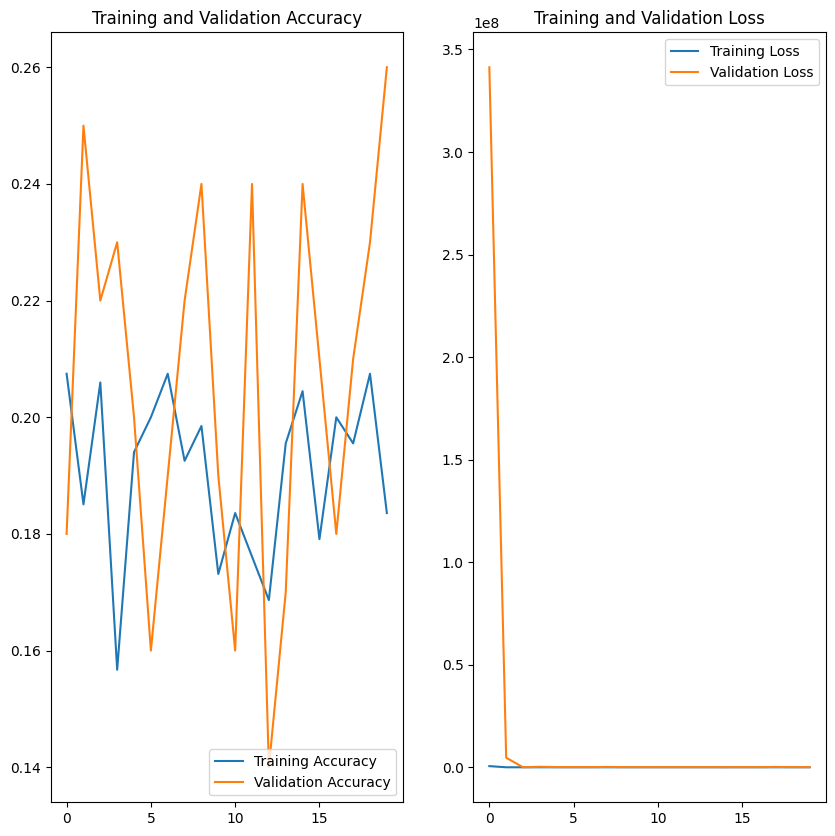

In [ ]:
acc = model.history.history['categorical_accuracy']
val_acc = model.history.history['val_categorical_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notes:
*   Changed the batch size from 50 to 30. A batch size of 50, consumed more GPU memory, leaving no room for training the model.
*   A batch size of 30 too consumed more GPU memory and resulted in an error.
*   For ablation experiment, using a batch size of 10 and image samples value of 5. Training underway.
*   List item






Reference:</br>
imread, imresize - https://github.com/cs231n/cs231n.github.io/issues/187</br>
Tensorflow random seed value - https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/random/set_seed</br>
Checkpoint - https://stackoverflow.com/questions/60325561/val-loss-missing-in-keras-logs-but-correctly-printed-at-the-end-of-epochs#:~:text=The%20issue%20was%20caused%20by%20some%20confusion%20between,the%20val_loss%20is%20computed%20and%20included%20in%20logs.